In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Embedding, LSTM, Bidirectional, GRU, Conv1D, MaxPooling1D,
    Dense, Dropout, GlobalMaxPooling1D, Flatten, SpatialDropout1D
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)

print("✅ Bibliothèques importées")
print(f"TensorFlow version: {tf.__version__}")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

✅ Bibliothèques importées
TensorFlow version: 2.20.0


CHARGEMENT DES DONNÉES

In [2]:
print("\n" + "="*70)
print("CHARGEMENT DES DONNÉES PRÉPROCESSÉES")
print("="*70)

# Charger les données
X_train = np.load('DataSet/X_train.npy')
X_val = np.load('DataSet/X_val.npy')
X_test = np.load('DataSet/X_test.npy')
y_train = np.load('DataSet/y_train.npy')
y_val = np.load('DataSet/y_val.npy')
y_test = np.load('DataSet/y_test.npy')

# Charger les paramètres
with open('models/preprocessing_params.pkl', 'rb') as f:
    params = pickle.load(f)

VOCAB_SIZE = params['vocab_size']
MAX_LENGTH = params['max_length']
CLASS_WEIGHTS = params['class_weights']

print(f"✅ Données chargées:")
print(f"  - Train: {X_train.shape}")
print(f"  - Validation: {X_val.shape}")
print(f"  - Test: {X_test.shape}")
print(f"\n  - Vocab Size: {VOCAB_SIZE}")
print(f"  - Max Length: {MAX_LENGTH}")
print(f"  - Class Weights: {CLASS_WEIGHTS}")


CHARGEMENT DES DONNÉES PRÉPROCESSÉES
✅ Données chargées:
  - Train: (3618, 100)
  - Validation: (775, 100)
  - Test: (776, 100)

  - Vocab Size: 10000
  - Max Length: 100
  - Class Weights: {0: np.float64(0.5722872508699779), 1: np.float64(3.9584245076586435)}


HYPERPARAMÈTRES COMMUNS

In [3]:
print("\n" + "="*70)
print("HYPERPARAMÈTRES OPTIMISÉS")
print("="*70)

# Hyperparamètres
EMBEDDING_DIM = 128
LSTM_UNITS = 64
GRU_UNITS = 64
CNN_FILTERS = 128
DROPOUT_RATE = 0.5
SPATIAL_DROPOUT = 0.2
LEARNING_RATE = 0.0005  # Réduit pour plus de stabilité
BATCH_SIZE = 32
EPOCHS = 50  # Augmenté

print(f"""
Hyperparamètres optimisés:
  - Embedding Dimension: {EMBEDDING_DIM}
  - LSTM/GRU Units: {LSTM_UNITS}/{GRU_UNITS}
  - CNN Filters: {CNN_FILTERS}
  - Dropout Rate: {DROPOUT_RATE}
  - Spatial Dropout: {SPATIAL_DROPOUT}
  - Learning Rate: {LEARNING_RATE} (réduit)
  - Batch Size: {BATCH_SIZE}
  - Max Epochs: {EPOCHS} (augmenté)
""")

# Callbacks optimisés
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,  # Augmenté de 3 à 7
    restore_best_weights=True,
    verbose=1,
    min_delta=0.001  # Ignore les petites variations
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,  # Augmenté de 2 à 5
    min_lr=1e-7,
    verbose=1
)

print(f"""
Callbacks configurés:
  - Early Stopping: patience=7, min_delta=0.001
  - Reduce LR: patience=5, factor=0.5, min_lr=1e-7
   Ces paramètres permettent un entraînement plus long et stable
""")



HYPERPARAMÈTRES OPTIMISÉS

Hyperparamètres optimisés:
  - Embedding Dimension: 128
  - LSTM/GRU Units: 64/64
  - CNN Filters: 128
  - Dropout Rate: 0.5
  - Spatial Dropout: 0.2
  - Learning Rate: 0.0005 (réduit)
  - Batch Size: 32
  - Max Epochs: 50 (augmenté)


Callbacks configurés:
  - Early Stopping: patience=7, min_delta=0.001
  - Reduce LR: patience=5, factor=0.5, min_lr=1e-7
   Ces paramètres permettent un entraînement plus long et stable



MODÈLE 1: SIMPLE LSTM

In [5]:
print("\n" + "="*70)
print("MODÈLE 1: SIMPLE LSTM (AMÉLIORÉ)")
print("="*70)

model_lstm = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LENGTH),
    SpatialDropout1D(SPATIAL_DROPOUT),  # Dropout sur embeddings
    LSTM(LSTM_UNITS, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
    Dropout(DROPOUT_RATE),
    Dense(32, activation='relu'),
    Dropout(DROPOUT_RATE),
    Dense(1, activation='sigmoid')
], name='Simple_LSTM')

model_lstm.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

print(model_lstm.summary())
#print(f"\n📊 Total Parameters: {model_lstm.count_params():,}")

# Entraînement
print("\n🚀 Entraînement LSTM...")
checkpoint_lstm = ModelCheckpoint('models/lstm_best.keras', save_best_only=True, monitor='val_loss', verbose=1)

history_lstm = model_lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=CLASS_WEIGHTS,
    callbacks=[early_stopping, reduce_lr, checkpoint_lstm],
    verbose=1
)

print(f"✅ LSTM entraîné! Epochs effectués: {len(history_lstm.history['loss'])}")


MODÈLE 1: SIMPLE LSTM (AMÉLIORÉ)


Model: "Simple_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None

🚀 Entraînement LSTM...
Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5169 - auc_1: 0.4838 - loss: 0.6812 - precision_1: 0.1157 - recall_1: 0.4511
Epoch 1: val_loss improved from None to 0.70105, saving model to models/lstm_best.keras

Epoch 1: finished saving model to models/lstm_best.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.4486 - auc_1: 0.4789 - loss: 0.6959 - precision_1: 0.1212 - recall_1: 0.5383 - val_accuracy: 0.1265 - val_auc_1: 0.5000 - val_loss: 0.7011 - val_precision_1: 0.1265 - val_recall_1: 1.0000 - learning_rate: 5.0000e-04
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4917 - auc_1: 0.4921 - loss: 0.6796 - precision_1: 0.1163 - recall_1: 0.4897
Epoch 2: val_loss did not improve from 0.70105
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.4583 - auc_1: 0.4983 - loss: 0.6945 - precision_1: 0.1278 - recall_1: 0.5646 - val_accuracy: 0.1265 - val_auc_1: 0.5000 - val_loss: 0.7086 - val_precision_1: 0.1

MODÈLE 2: BIDIRECTIONAL LSTM

In [7]:
print("\n" + "="*70)
print("MODÈLE 2: BIDIRECTIONAL LSTM (AMÉLIORÉ)")
print("="*70)

model_bilstm = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LENGTH),
    SpatialDropout1D(SPATIAL_DROPOUT),
    Bidirectional(LSTM(LSTM_UNITS, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)),
    Dropout(DROPOUT_RATE),
    Dense(32, activation='relu'),
    Dropout(DROPOUT_RATE),
    Dense(1, activation='sigmoid')
], name='BiLSTM')

model_bilstm.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

print(model_bilstm.summary())
#print(f"\n📊 Total Parameters: {model_bilstm.count_params():,}")

# Entraînement
print("\n🚀 Entraînement BiLSTM...")
checkpoint_bilstm = ModelCheckpoint('models/bilstm_best.keras', save_best_only=True, monitor='val_loss', verbose=1)

# Reset early stopping
early_stopping_bilstm = EarlyStopping(
    monitor='val_loss', patience=7, restore_best_weights=True, verbose=1, min_delta=0.001
)

history_bilstm = model_bilstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=CLASS_WEIGHTS,
    callbacks=[early_stopping_bilstm, reduce_lr, checkpoint_bilstm],
    verbose=1
)

print(f"✅ BiLSTM entraîné! Epochs effectués: {len(history_bilstm.history['loss'])}")


MODÈLE 2: BIDIRECTIONAL LSTM (AMÉLIORÉ)


Model: "BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_3             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None

🚀 Entraînement BiLSTM...
Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7892 - auc_3: 0.6723 - loss: 0.6409 - precision_3: 0.2517 - recall_3: 0.3760
Epoch 1: val_loss improved from None to 0.36353, saving model to models/bilstm_best.keras

Epoch 1: finished saving model to models/bilstm_best.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - accuracy: 0.8074 - auc_3: 0.7906 - loss: 0.5898 - precision_3: 0.3429 - recall_3: 0.5733 - val_accuracy: 0.8103 - val_auc_3: 0.9490 - val_loss: 0.3635 - val_precision_3: 0.3891 - val_recall_3: 0.8776 - learning_rate: 5.0000e-04
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8956 - auc_3: 0.9545 - loss: 0.2903 - precision_3: 0.5432 - recall_3: 0.8871
Epoch 2: val_loss improved from 0.36353 to 0.12904, saving model to models/bilstm_best.keras

Epoch 2: finished saving model to models/bilstm_best.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - accuracy: 0.9243 - auc_3: 0.9697 - loss: 0.2355 - precision_

 MODÈLE 3: GRU

In [9]:

print("\n" + "="*70)
print("MODÈLE 3: GRU (AMÉLIORÉ)")
print("="*70)

model_gru = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LENGTH),
    SpatialDropout1D(SPATIAL_DROPOUT),
    GRU(GRU_UNITS, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
    Dropout(DROPOUT_RATE),
    Dense(32, activation='relu'),
    Dropout(DROPOUT_RATE),
    Dense(1, activation='sigmoid')
], name='GRU')

model_gru.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)



# Entraînement
print("\n🚀 Entraînement GRU...")
checkpoint_gru = ModelCheckpoint('models/gru_best.keras', save_best_only=True, monitor='val_loss', verbose=1)

early_stopping_gru = EarlyStopping(
    monitor='val_loss', patience=7, restore_best_weights=True, verbose=1, min_delta=0.001
)

history_gru = model_gru.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=CLASS_WEIGHTS,
    callbacks=[early_stopping_gru, reduce_lr, checkpoint_gru],
    verbose=1
)

print(f"✅ GRU entraîné! Epochs effectués: {len(history_gru.history['loss'])}")


MODÈLE 3: GRU (AMÉLIORÉ)

🚀 Entraînement GRU...
Epoch 1/50
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5309 - auc_5: 0.4514 - loss: 0.6817 - precision_5: 0.1087 - recall_5: 0.3998
Epoch 1: val_loss improved from None to 0.69132, saving model to models/gru_best.keras

Epoch 1: finished saving model to models/gru_best.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.4643 - auc_5: 0.4885 - loss: 0.6953 - precision_5: 0.1254 - recall_5: 0.5427 - val_accuracy: 0.8735 - val_auc_5: 0.5000 - val_loss: 0.6913 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 2/50
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5838 - auc_5: 0.5111 - loss: 0.6784 - precision_5: 0.1282 - recall_5: 0.4354
Epoch 2: val_loss did not improve from 0.69132
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.5216 - auc_5: 0.5123 - loss: 0.6936 - precision_5: 0.1347 - recall_5: 0.5142 - val_accuracy: 0.1265 - val_auc_5: 0.5000 - val_loss: 0.7

MODÈLE 4: CNN 1D

In [11]:
print("\n" + "="*70)
print("MODÈLE 4: CNN 1D (AMÉLIORÉ)")
print("="*70)

model_cnn = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LENGTH),
    SpatialDropout1D(SPATIAL_DROPOUT),
    Conv1D(filters=CNN_FILTERS, kernel_size=5, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(DROPOUT_RATE),
    Dense(1, activation='sigmoid')
], name='CNN_1D')

model_cnn.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

print(model_cnn.summary())

# Entraînement
print("\n🚀 Entraînement CNN...")
checkpoint_cnn = ModelCheckpoint('models/cnn_best.keras', save_best_only=True, monitor='val_loss', verbose=1)

early_stopping_cnn = EarlyStopping(
    monitor='val_loss', patience=7, restore_best_weights=True, verbose=1, min_delta=0.001
)

history_cnn = model_cnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=CLASS_WEIGHTS,
    callbacks=[early_stopping_cnn, reduce_lr, checkpoint_cnn],
    verbose=1
)

print(f"✅ CNN entraîné! Epochs effectués: {len(history_cnn.history['loss'])}")


MODÈLE 4: CNN 1D (AMÉLIORÉ)


Model: "CNN_1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_7             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None

🚀 Entraînement CNN...
Epoch 1/50
112/114 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7897 - auc_7: 0.6287 - loss: 0.6439 - precision_7: 0.2219 - recall_7: 0.3445
Epoch 1: val_loss improved from None to 0.26885, saving model to models/cnn_best.keras

Epoch 1: finished saving model to models/cnn_best.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8024 - auc_7: 0.8162 - loss: 0.5501 - precision_7: 0.3423 - recall_7: 0.6127 - val_accuracy: 0.9316 - val_auc_7: 0.9827 - val_loss: 0.2689 - val_precision_7: 0.6552 - val_recall_7: 0.9694 - learning_rate: 5.0000e-04
Epoch 2/50
110/114 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9498 - auc_7: 0.9696 - loss: 0.1907 - precision_7: 0.7319 - recall_7: 0.9005
Epoch 2: val_loss improved from 0.26885 to 0.11226, saving model to models/cnn_best.keras

Epoch 2: finished saving model to models/cnn_best.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9677 - auc_7: 0.9817 - loss: 0.1457 - precision_7: 0.8295 - recal

 RÉSUMÉ DES ENTRAÎNEMENTS

In [12]:
print("\n" + "="*70)
print("RÉSUMÉ DES ENTRAÎNEMENTS")
print("="*70)

training_summary = {
    'LSTM': {
        'epochs': len(history_lstm.history['loss']),
        'best_val_loss': min(history_lstm.history['val_loss']),
        'best_val_acc': max(history_lstm.history['val_accuracy'])
    },
    'BiLSTM': {
        'epochs': len(history_bilstm.history['loss']),
        'best_val_loss': min(history_bilstm.history['val_loss']),
        'best_val_acc': max(history_bilstm.history['val_accuracy'])
    },
    'GRU': {
        'epochs': len(history_gru.history['loss']),
        'best_val_loss': min(history_gru.history['val_loss']),
        'best_val_acc': max(history_gru.history['val_accuracy'])
    },
    'CNN': {
        'epochs': len(history_cnn.history['loss']),
        'best_val_loss': min(history_cnn.history['val_loss']),
        'best_val_acc': max(history_cnn.history['val_accuracy'])
    }
}

for model_name, stats in training_summary.items():
    print(f"\n{model_name}:")
    print(f"  - Epochs: {stats['epochs']}")
    print(f"  - Best Val Loss: {stats['best_val_loss']:.4f}")
    print(f"  - Best Val Accuracy: {stats['best_val_acc']:.4f}")


RÉSUMÉ DES ENTRAÎNEMENTS

LSTM:
  - Epochs: 16
  - Best Val Loss: 0.6832
  - Best Val Accuracy: 0.8735

BiLSTM:
  - Epochs: 13
  - Best Val Loss: 0.0730
  - Best Val Accuracy: 0.9742

GRU:
  - Epochs: 10
  - Best Val Loss: 0.6838
  - Best Val Accuracy: 0.8735

CNN:
  - Epochs: 13
  - Best Val Loss: 0.0801
  - Best Val Accuracy: 0.9794


VISUALISATION DES COURBES D'APPRENTISSAGE


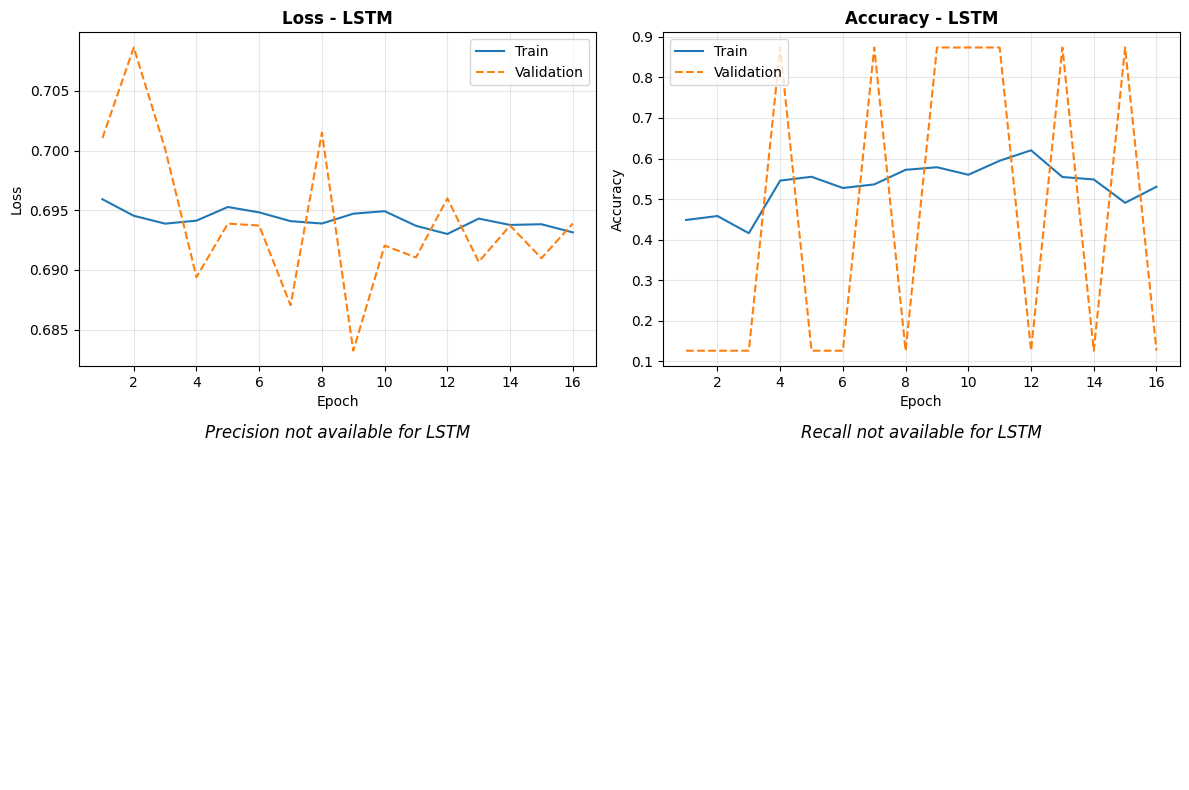

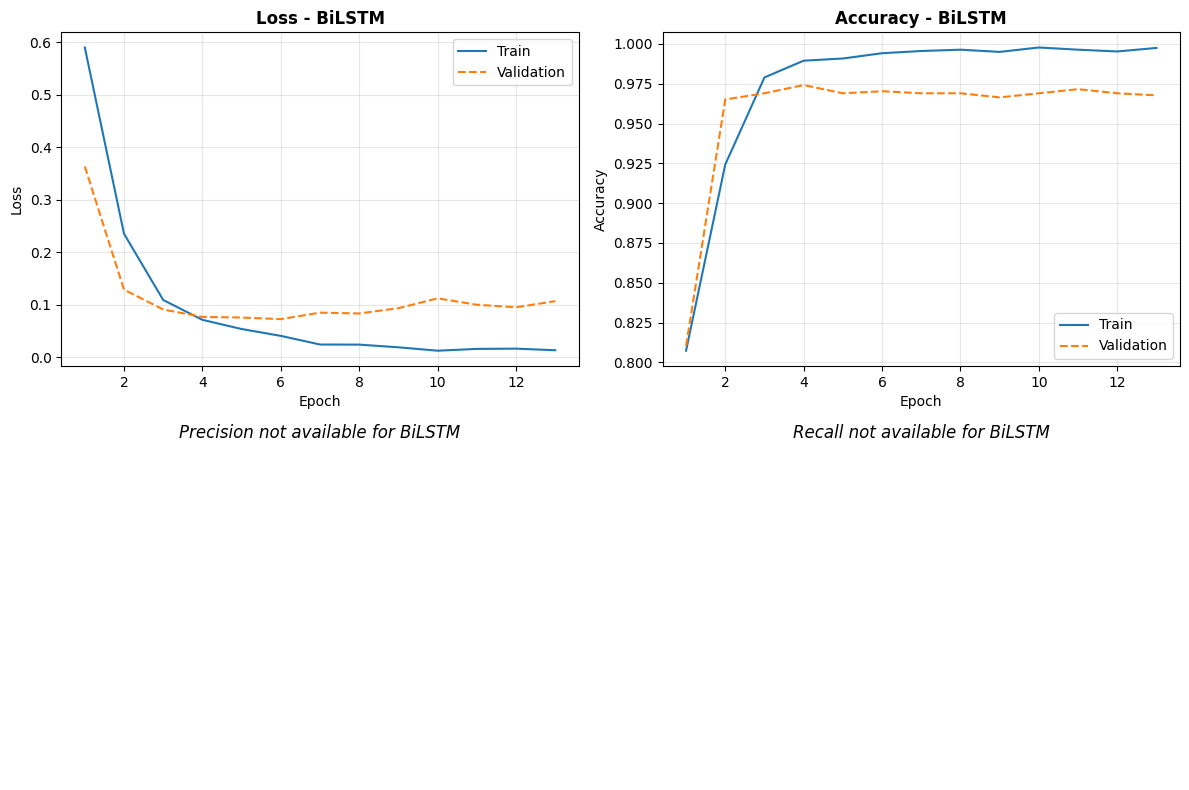

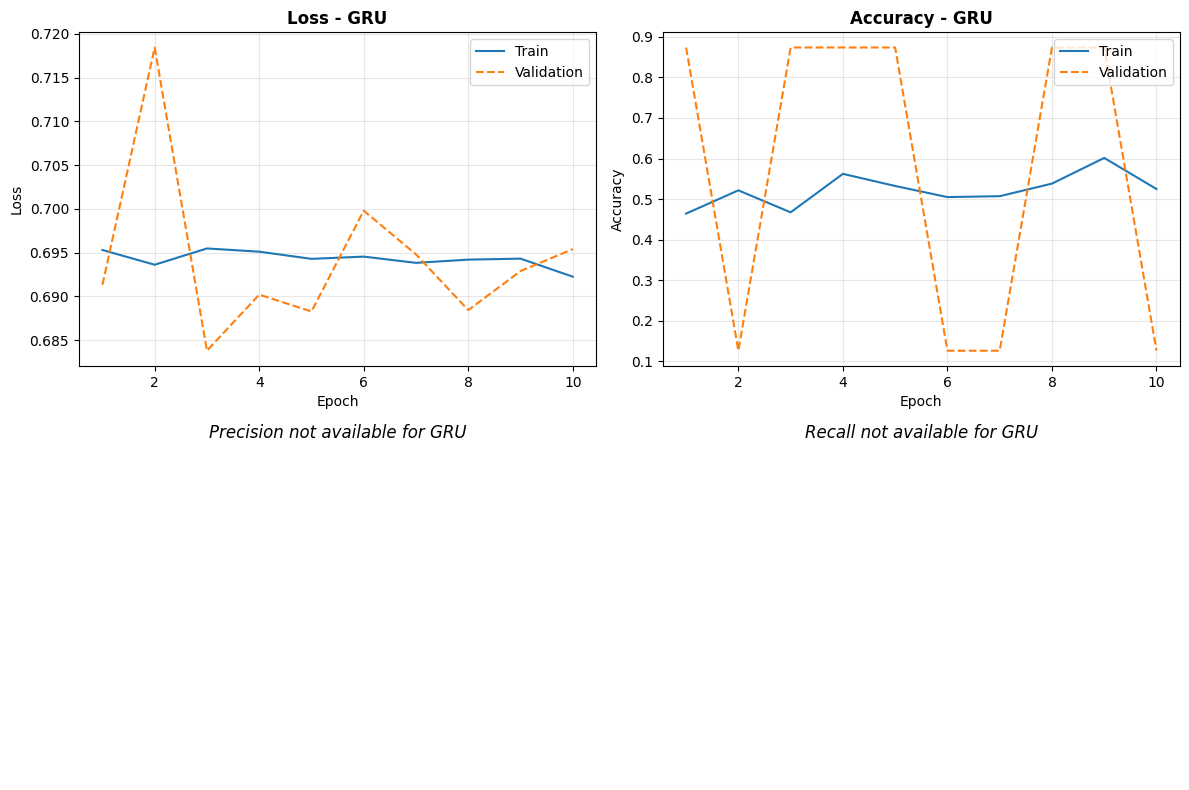

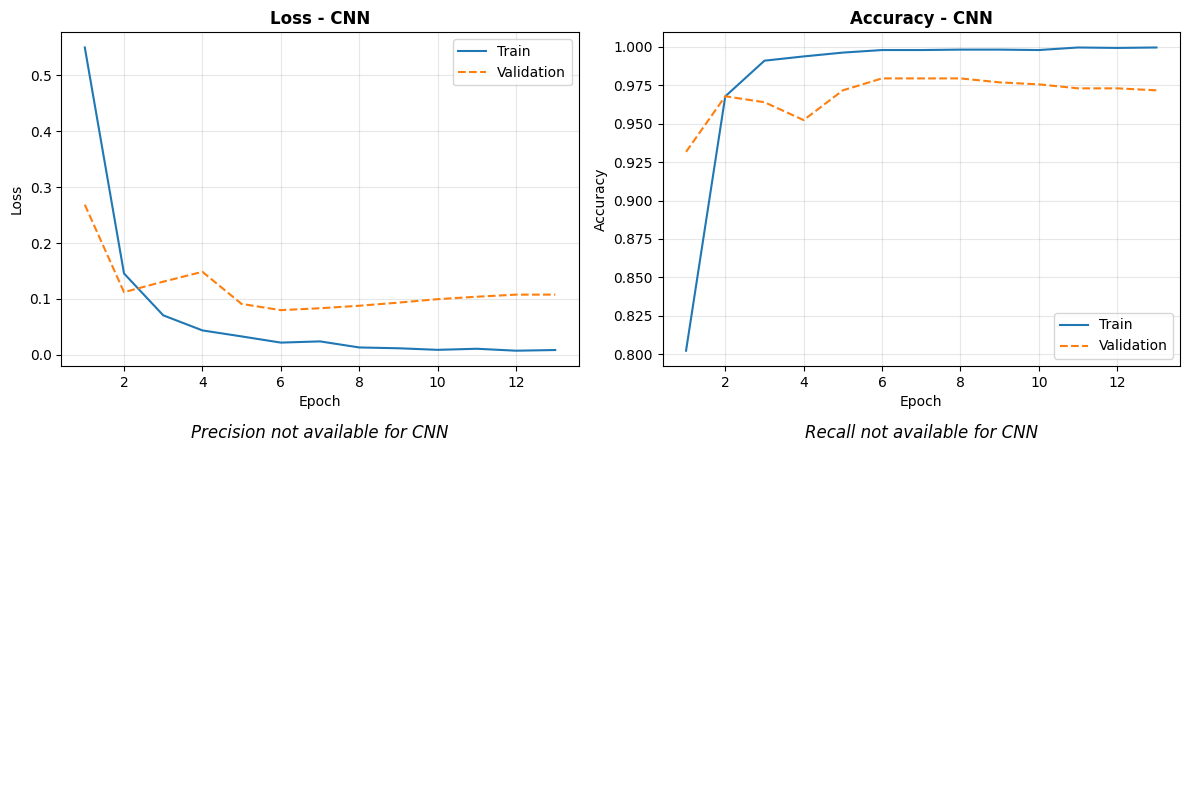

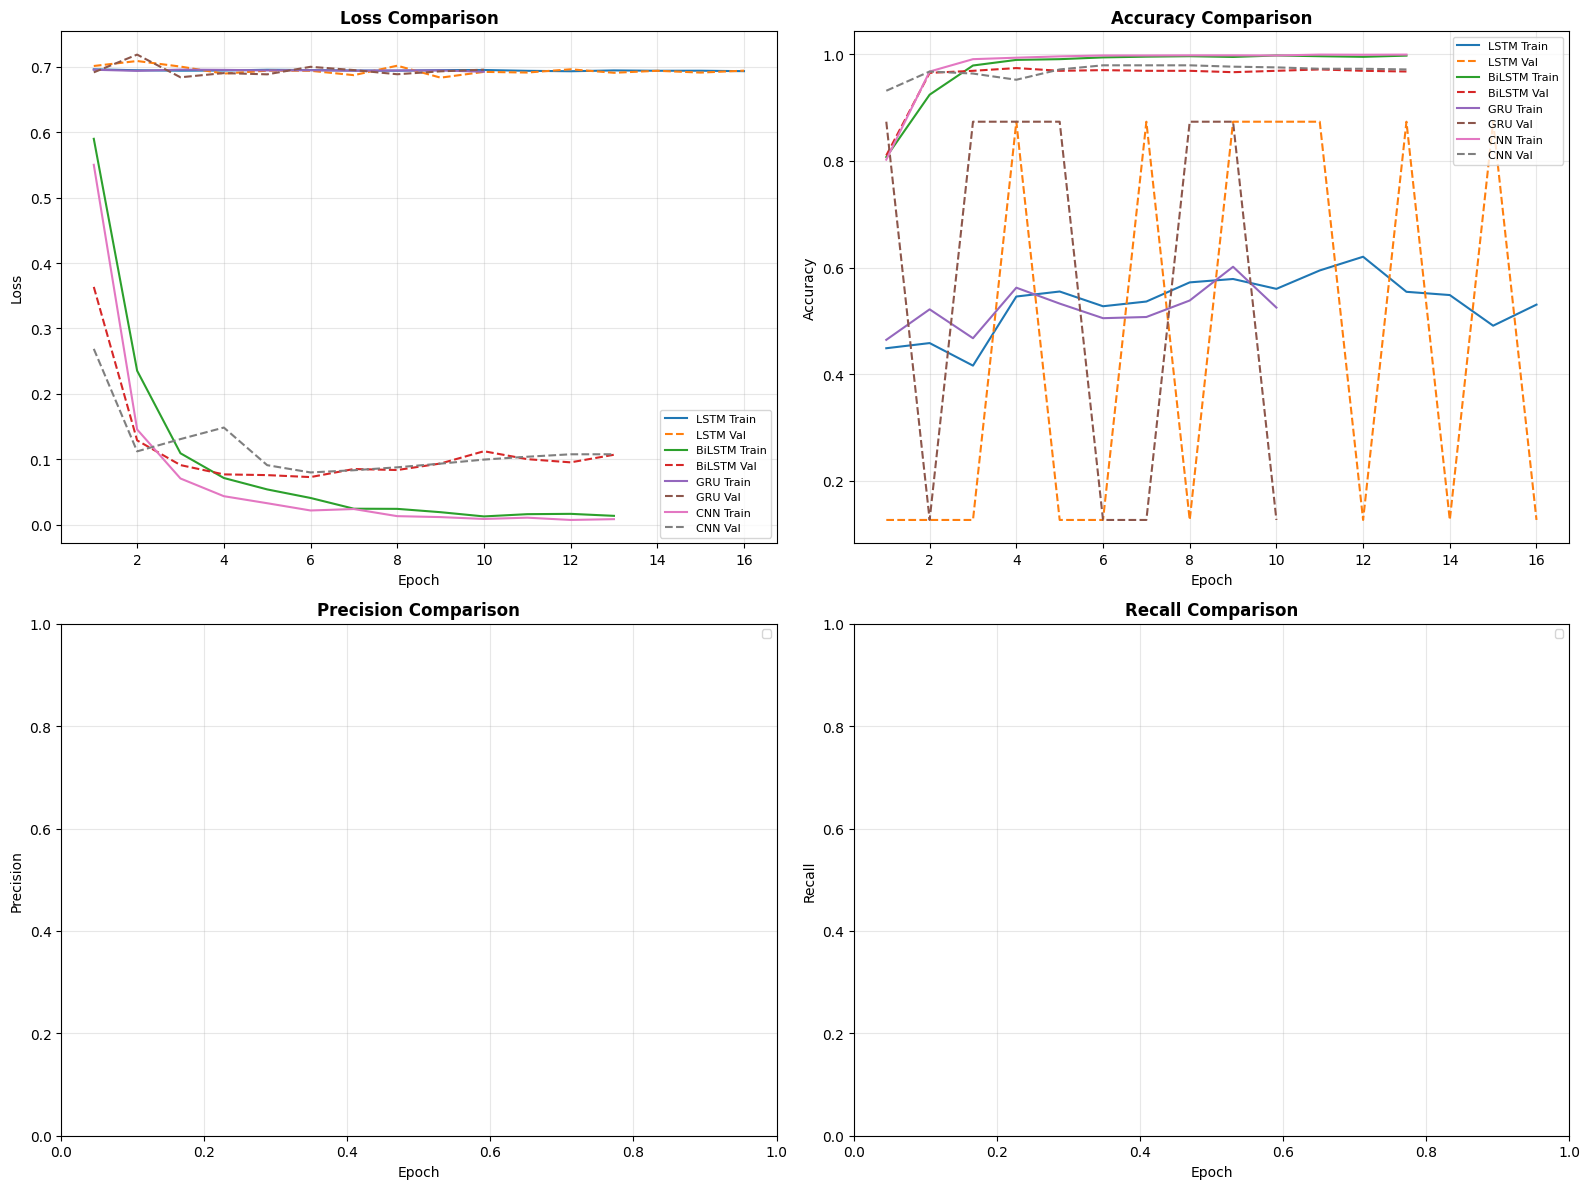

In [ ]:
import matplotlib.pyplot as plt
import os

os.makedirs("results/training_curves", exist_ok=True)

def plot_single_model(history, name):
    """Courbes loss & accuracy pour un modèle"""
    epochs = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(8,5))
    plt.plot(epochs, history.history['loss'], label="Train Loss")
    plt.plot(epochs, history.history['val_loss'], linestyle="--", label="Val Loss")
    plt.title(f"Loss - {name}", fontweight="bold")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f"results/training_curves/{name.lower()}_loss.png", dpi=300)
    plt.show()

    plt.figure(figsize=(8,5))
    plt.plot(epochs, history.history['accuracy'], label="Train Accuracy")
    plt.plot(epochs, history.history['val_accuracy'], linestyle="--", label="Val Accuracy")
    plt.title(f"Accuracy - {name}", fontweight="bold")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f"results/training_curves/{name.lower()}_accuracy.png", dpi=300)
    plt.show()


def plot_comparison(histories, names):
    """Comparaison globale des 4 modèles (loss & accuracy)"""
    plt.figure(figsize=(10,6))
    for history, name in zip(histories, names):
        epochs = range(1, len(history.history['loss']) + 1)
        plt.plot(epochs, history.history['loss'], label=f"{name} Train Loss")
        plt.plot(epochs, history.history['val_loss'], linestyle="--", label=f"{name} Val Loss")

    plt.title("Loss Comparison", fontweight="bold")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.savefig("results/training_curves/loss_comparison.png", dpi=300)
    plt.show()

    plt.figure(figsize=(10,6))
    for history, name in zip(histories, names):
        epochs = range(1, len(history.history['accuracy']) + 1)
        plt.plot(epochs, history.history['accuracy'], label=f"{name} Train Acc")
        plt.plot(epochs, history.history['val_accuracy'], linestyle="--", label=f"{name} Val Acc")

    plt.title("Accuracy Comparison", fontweight="bold")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.savefig("results/training_curves/accuracy_comparison.png", dpi=300)
    plt.show()


# Plot par modèle
plot_single_model(history_lstm, "LSTM")
plot_single_model(history_bilstm, "BiLSTM")
plot_single_model(history_gru, "GRU")
plot_single_model(history_cnn, "CNN")

# Comparaison finale
plot_comparison(
    [history_lstm, history_bilstm, history_gru, history_cnn],
    ["LSTM", "BiLSTM", "GRU", "CNN"]
)


ÉVALUATION SUR LE TEST SET

In [16]:
print("\n" + "="*70)
print("ÉVALUATION SUR LE TEST SET")
print("="*70)

models = {
    'LSTM': model_lstm,
    'BiLSTM': model_bilstm,
    'GRU': model_gru,
    'CNN': model_cnn
}

results = {}

for name, model in models.items():
    print(f"\n{name}:")
    print("-" * 50)
    
    # Prédictions
    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    
    # Métriques
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results[name] = {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba.flatten()
    }
    
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1-Score:  {f1:.4f}")


ÉVALUATION SUR LE TEST SET

LSTM:
--------------------------------------------------
  Accuracy:  0.8737
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

BiLSTM:
--------------------------------------------------
  Accuracy:  0.9794
  Precision: 0.9100
  Recall:    0.9286
  F1-Score:  0.9192

GRU:
--------------------------------------------------
  Accuracy:  0.8737
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

CNN:
--------------------------------------------------
  Accuracy:  0.9755
  Precision: 0.8990
  Recall:    0.9082
  F1-Score:  0.9036


TABLEAU COMPARATIF DES PERFORMANCES


TABLEAU COMPARATIF DES PERFORMANCES
 Model  Accuracy  Precision   Recall  F1-Score
BiLSTM  0.979381   0.955556 0.877551  0.914894
   CNN  0.965206   0.825688 0.918367  0.869565
   GRU  0.126289   0.126289 1.000000  0.224256
  LSTM  0.873711   0.000000 0.000000  0.000000


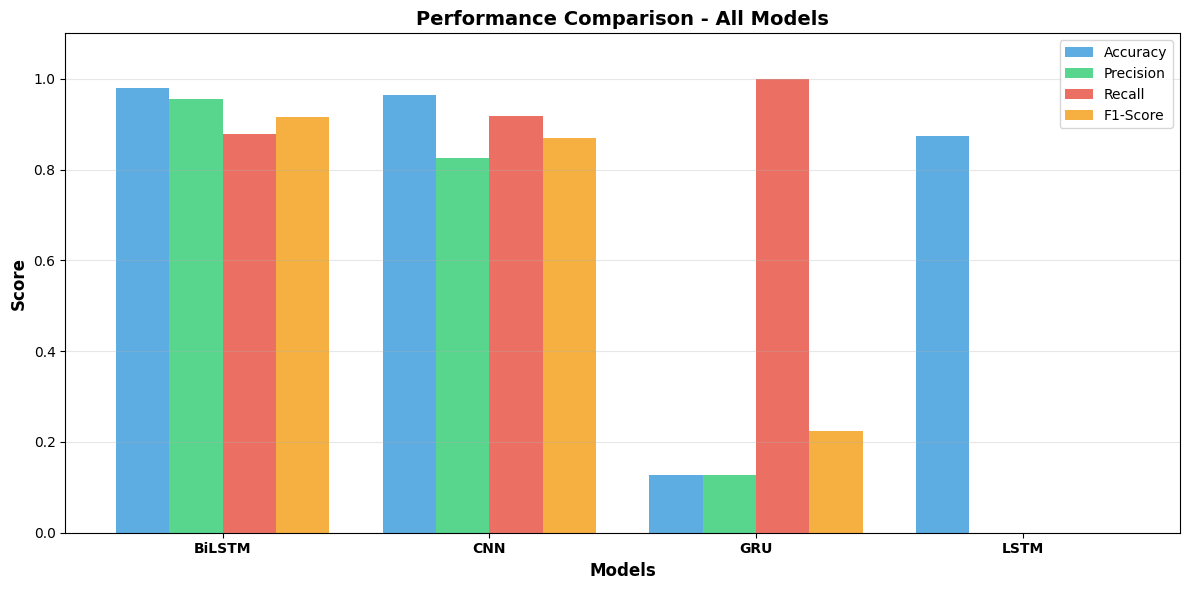

In [ ]:
print("\n" + "="*70)
print("TABLEAU COMPARATIF DES PERFORMANCES")
print("="*70)

# Créer un DataFrame avec les résultats
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1-Score': [results[m]['f1_score'] for m in results.keys()]
})

results_df = results_df.sort_values('F1-Score', ascending=False)
print("\n" + results_df.to_string(index=False))

# Visualisation
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(results_df))
width = 0.2

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

for i, (metric, color) in enumerate(zip(metrics, colors)):
    ax.bar(x + i*width, results_df[metric], width, label=metric, color=color, alpha=0.8, edgecolor='black')

ax.set_xlabel('Models', fontweight='bold', fontsize=12)
ax.set_ylabel('Score', fontweight='bold', fontsize=12)
ax.set_title('Performance Comparison - All Models', fontweight='bold', fontsize=14)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(results_df['Model'], fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.1])

# Ajouter les valeurs sur les barres
for i, metric in enumerate(metrics):
    for j, value in enumerate(results_df[metric]):
        ax.text(j + i*width, value + 0.02, f'{value:.3f}', 
                ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig('results/models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

MATRICES DE CONFUSION


MATRICES DE CONFUSION


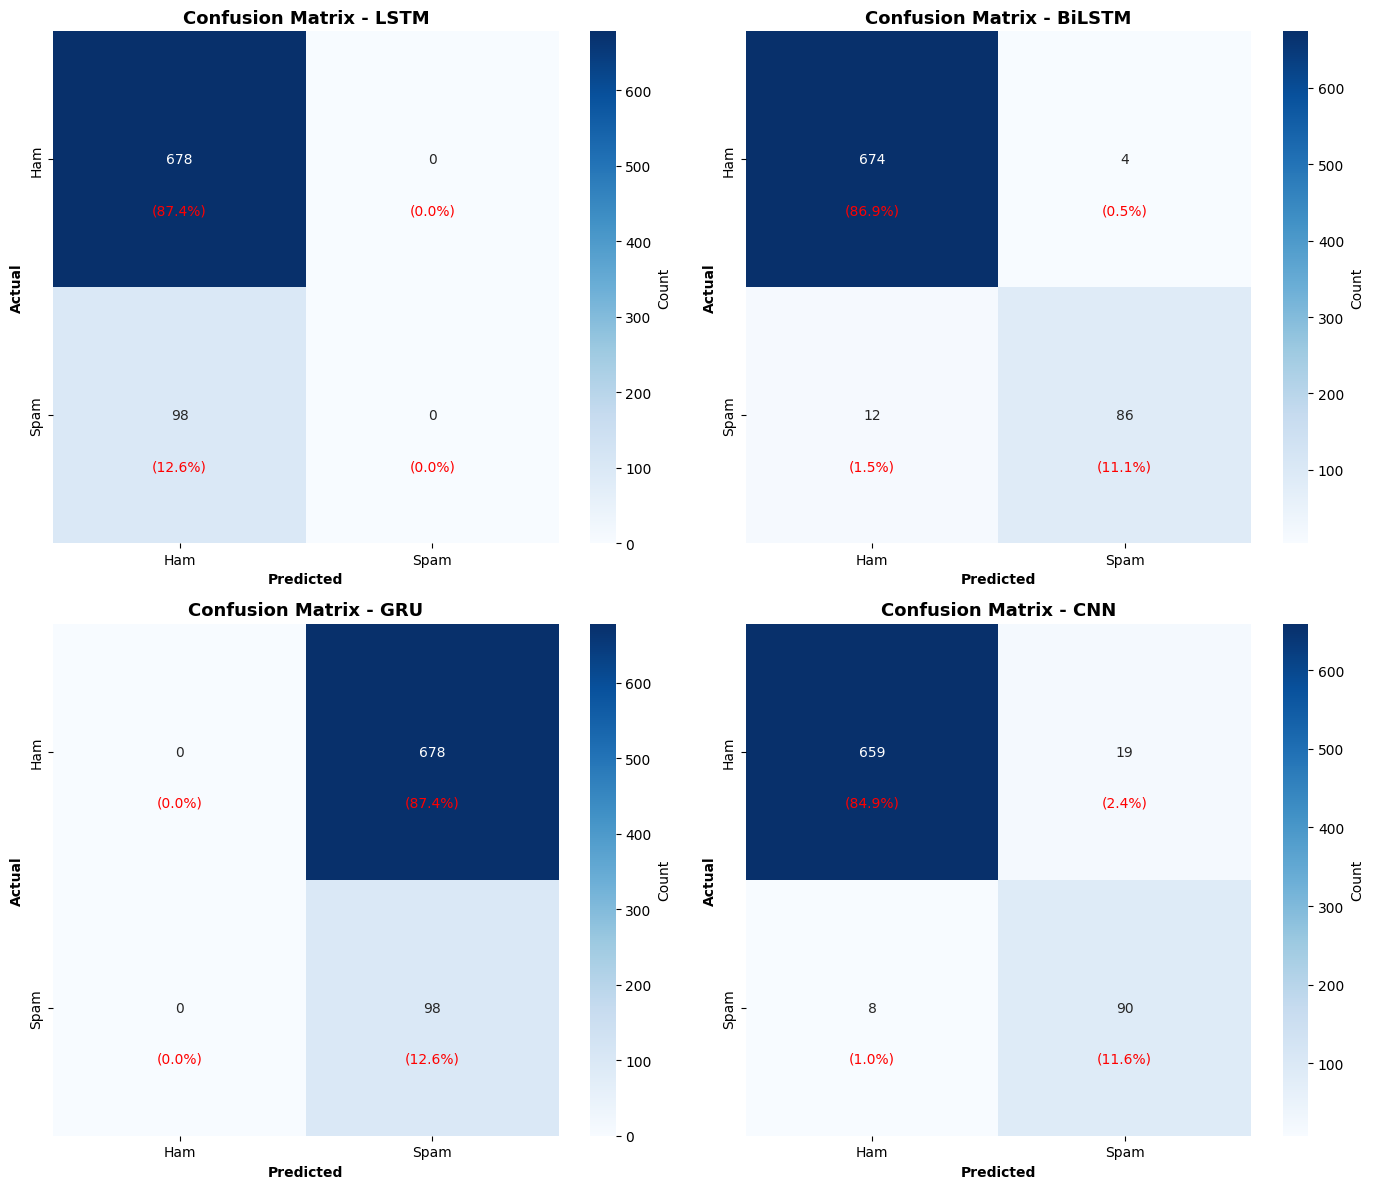

In [ ]:
print("\n" + "="*70)
print("MATRICES DE CONFUSION")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for ax, (name, result) in zip(axes.flat, results.items()):
    cm = confusion_matrix(y_test, result['y_pred'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'],
                cbar_kws={'label': 'Count'}, annot_kws={'size': 14, 'weight': 'bold'})
    
    ax.set_xlabel('Predicted', fontweight='bold', fontsize=12)
    ax.set_ylabel('Actual', fontweight='bold', fontsize=12)
    ax.set_title(f'Confusion Matrix - {name}', fontweight='bold', fontsize=13)
    
    # Ajouter les pourcentages
    total = cm.sum()
    for i in range(2):
        for j in range(2):
            percentage = cm[i, j] / total * 100
            ax.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                   ha='center', va='center', fontsize=10, color='red', fontweight='bold')

plt.tight_layout()
plt.savefig('results/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

COURBES ROC


COURBES ROC


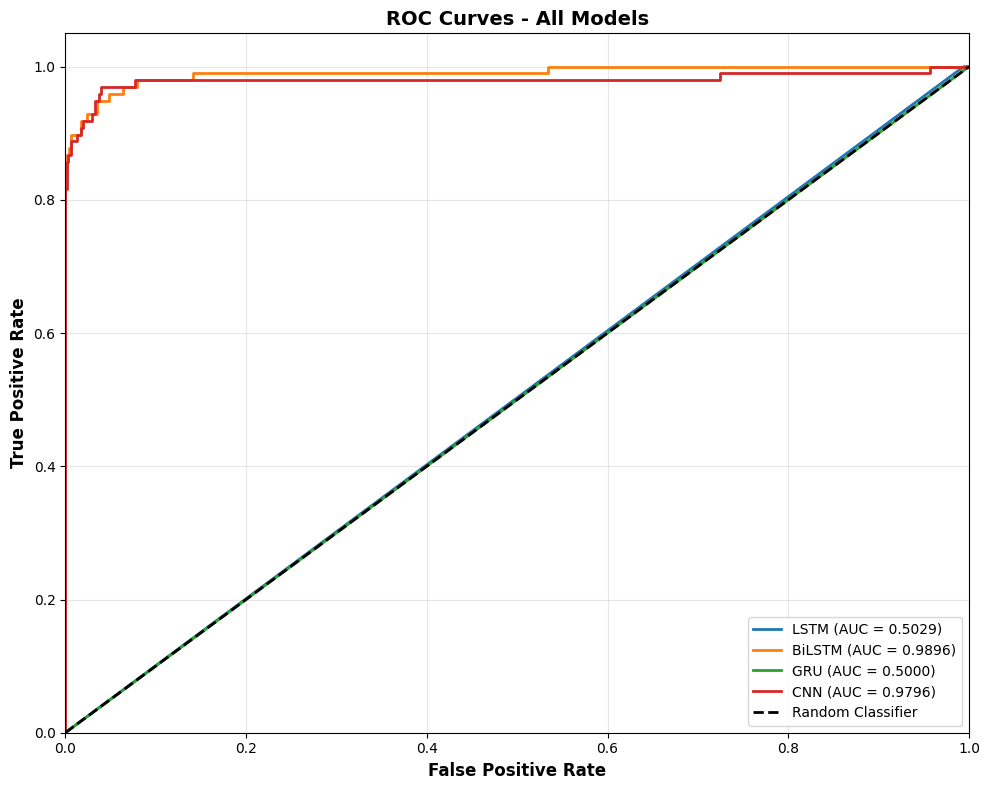

In [ ]:
print("\n" + "="*70)
print("COURBES ROC")
print("="*70)

plt.figure(figsize=(10, 8))

for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, linewidth=2.5, label=f'{name} (AUC = {roc_auc:.4f})', marker='o', markersize=4)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontweight='bold', fontsize=12)
plt.ylabel('True Positive Rate', fontweight='bold', fontsize=12)
plt.title('ROC Curves - All Models', fontweight='bold', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

CLASSIFICATION REPORTS

In [18]:
print("\n" + "="*70)
print("CLASSIFICATION REPORTS")
print("="*70)

for name, result in results.items():
    print(f"\n{name}:")
    print("=" * 50)
    print(classification_report(y_test, result['y_pred'], 
                                target_names=['Ham', 'Spam'], digits=4))


CLASSIFICATION REPORTS

LSTM:
              precision    recall  f1-score   support

         Ham     0.8737    1.0000    0.9326       678
        Spam     0.0000    0.0000    0.0000        98

    accuracy                         0.8737       776
   macro avg     0.4369    0.5000    0.4663       776
weighted avg     0.7634    0.8737    0.8148       776


BiLSTM:
              precision    recall  f1-score   support

         Ham     0.9825    0.9941    0.9883       678
        Spam     0.9556    0.8776    0.9149        98

    accuracy                         0.9794       776
   macro avg     0.9690    0.9358    0.9516       776
weighted avg     0.9791    0.9794    0.9790       776


GRU:
              precision    recall  f1-score   support

         Ham     0.0000    0.0000    0.0000       678
        Spam     0.1263    1.0000    0.2243        98

    accuracy                         0.1263       776
   macro avg     0.0631    0.5000    0.1121       776
weighted avg     0.0159    0

ANALYSE DES ERREURS


ANALYSE DES ERREURS (Meilleur modèle)
Meilleur modèle: BiLSTM
F1-Score: 0.9149

Nombre d'erreurs: 16 / 776 (2.06%)

Faux Positifs (Ham prédit comme Spam): 4
Faux Négatifs (Spam prédit comme Ham): 12


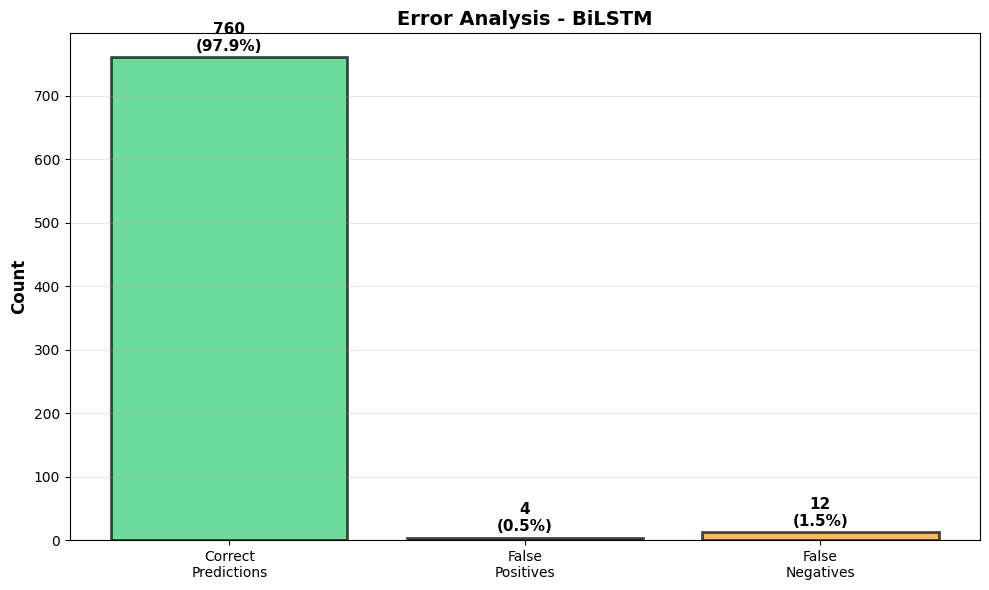

In [19]:
print("\n" + "="*70)
print("ANALYSE DES ERREURS (Meilleur modèle)")
print("="*70)

# Identifier le meilleur modèle
best_model_name = results_df.iloc[0]['Model']
best_result = results[best_model_name]

print(f"Meilleur modèle: {best_model_name}")
print(f"F1-Score: {best_result['f1_score']:.4f}")

# Trouver les erreurs
errors_idx = np.where(y_test != best_result['y_pred'])[0]
print(f"\nNombre d'erreurs: {len(errors_idx)} / {len(y_test)} ({len(errors_idx)/len(y_test)*100:.2f}%)")

# Analyser les types d'erreurs
false_positives = np.where((y_test == 0) & (best_result['y_pred'] == 1))[0]
false_negatives = np.where((y_test == 1) & (best_result['y_pred'] == 0))[0]

print(f"\nFaux Positifs (Ham prédit comme Spam): {len(false_positives)}")
print(f"Faux Négatifs (Spam prédit comme Ham): {len(false_negatives)}")

# Visualisation
fig, ax = plt.subplots(figsize=(10, 6))

error_types = ['Correct\nPredictions', 'False\nPositives', 'False\nNegatives']
counts = [len(y_test) - len(errors_idx), len(false_positives), len(false_negatives)]
colors_err = ['#2ecc71', '#e74c3c', '#f39c12']

bars = ax.bar(error_types, counts, color=colors_err, alpha=0.7, edgecolor='black', linewidth=2)

ax.set_ylabel('Count', fontweight='bold', fontsize=12)
ax.set_title(f'Error Analysis - {best_model_name}', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3, axis='y')

# Ajouter les valeurs et pourcentages
for bar, count in zip(bars, counts):
    height = bar.get_height()
    percentage = count / len(y_test) * 100
    ax.text(bar.get_x() + bar.get_width()/2., height + 5,
            f'{count}\n({percentage:.1f}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('results/error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

SAUVEGARDER LES RÉSULTATS

In [20]:
print("\n" + "="*70)
print("SAUVEGARDE DES RÉSULTATS")
print("="*70)

# Sauvegarder le DataFrame de résultats
results_df.to_csv('results/classic_models_results.csv', index=False)
print("✅ Résultats sauvegardés: results/classic_models_results.csv")

# Sauvegarder les résultats détaillés
with open('results/classic_models_detailed.pkl', 'wb') as f:
    pickle.dump(results, f)
print(" Résultats détaillés: results/classic_models_detailed.pkl")



SAUVEGARDE DES RÉSULTATS
✅ Résultats sauvegardés: results/classic_models_results.csv
 Résultats détaillés: results/classic_models_detailed.pkl


RÉSUMÉ FINAL

In [21]:
print("\n" + "="*70)
print("RÉSUMÉ FINAL - MODÈLES CLASSIQUES")
print("="*70)

print(f"""
 MEILLEUR MODÈLE: {best_model_name}
   - Accuracy:  {results[best_model_name]['accuracy']:.4f}
   - Precision: {results[best_model_name]['precision']:.4f}
   - Recall:    {results[best_model_name]['recall']:.4f}
   - F1-Score:  {results[best_model_name]['f1_score']:.4f}

 CLASSEMENT:
""")

for i, row in results_df.iterrows():
    print(f"   {i+1}. {row['Model']}: F1={row['F1-Score']:.4f}")

print(f"""
 FICHIERS SAUVEGARDÉS:
   - models/lstm_best.keras
   - models/bilstm_best.keras
   - models/gru_best.keras
   - models/cnn_best.keras
   - results/classic_models_results.csv
   - results/*.png (visualisations)

 PROCHAINES ÉTAPES:
   ✓ Modèles classiques entraînés
   → Notebook 4: Modèles Avancés (CNN-BiLSTM-Attention, BERT)
""")

print("="*70)
print("✅ ENTRAÎNEMENT TERMINÉ! Passe au Notebook 4")
print("="*70)


RÉSUMÉ FINAL - MODÈLES CLASSIQUES

 MEILLEUR MODÈLE: BiLSTM
   - Accuracy:  0.9794
   - Precision: 0.9556
   - Recall:    0.8776
   - F1-Score:  0.9149

 CLASSEMENT:

   2. BiLSTM: F1=0.9149
   4. CNN: F1=0.8696
   3. GRU: F1=0.2243
   1. LSTM: F1=0.0000

 FICHIERS SAUVEGARDÉS:
   - models/lstm_best.keras
   - models/bilstm_best.keras
   - models/gru_best.keras
   - models/cnn_best.keras
   - results/classic_models_results.csv
   - results/*.png (visualisations)

 PROCHAINES ÉTAPES:
   ✓ Modèles classiques entraînés
   → Notebook 4: Modèles Avancés (CNN-BiLSTM-Attention, BERT)

✅ ENTRAÎNEMENT TERMINÉ! Passe au Notebook 4
